In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, Optional
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from pydantic import Field, BaseModel
from dotenv import load_dotenv
from langchain_community.vectorstores import Chroma
from pymongo import MongoClient
from langchain_groq import ChatGroq


c:\Users\omarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:

embedding_function = HuggingFaceEmbeddings(model_name="BAAI/bge-large-en-v1.5")
llm = ChatGroq(model_name="llama-3.3-70b-versatile")

In [4]:
db = Chroma(
    collection_name="judicial_docs",
    embedding_function=embedding_function,
)
retriever = db.as_retriever(search_type="mmr", search_kwargs = {"k": 5})    


C:\Users\omarn\AppData\Local\Temp\ipykernel_30660\2578742720.py:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-chroma package and should be used instead. To use it run `pip install -U `langchain-chroma` and import as `from `langchain_chroma import Chroma``.
  db = Chroma(


In [5]:
client = MongoClient("mongodb://localhost:27017/")
dbMongo = client["Rag"]
collection = dbMongo["Document Storage"]

docs = list(collection.find())
print(docs)
    

[{'_id': 'doc1', 'type': 'صحيفة دعوى', 'metadata': {'court': 'محكمة القاهرة الابتدائية', 'case_number': '12345 لسنة 2025', 'plaintiff': 'أحمد محمد علي', 'defendant': 'شركة النور للتجارة', 'date_filed': '2025-12-02'}, 'text': 'محكمة القاهرة الابتدائية...\n\nمقدمة:\nبتاريخ 2 ديسمبر 2025، تقدم المدعي السيد أحمد محمد علي، بموجب هذه الصحيفة، بطلب دعوى قضائية ضد شركة النور للتجارة.\n\nالوقائع:\n1. بتاريخ 15 يناير 2025، وقع المدعي عقد بيع مع المدعى عليه...\n2. انتهكت الشركة شروط العقد بعدم تسليم البضاعة في الموعد المتفق عليه...\n\nالأسانيد القانونية:\nبموجب نصوص القانون المدني المصري، المادة 115، فإن عدم الوفاء بالتزامات العقد يُعد إخلالاً بالعقد...\n\nالطلبات:\n1. إلزام المدعى عليه بتسليم البضاعة المتفق عليها.\n2. تعويض المدعي عن الأضرار المادية والمعنوية الناتجة عن التأخير.\n3. إلزام المدعى عليه بالمصاريف القضائية.\n\nالمستندات المرفقة:\n- نسخة من العقد الأصلي.\n- إيصالات الدفع.\n- مراسلات بين الطرفين.\n\nالختام:\nوبناءً على ما سبق، يلتمس المدعي قبول الدعوى وإصدار حكم لصالحه وفقاً للقانون.\

In [6]:
template = """
أنت مساعد قانوني متخصص يعمل مع قضاة المحاكم المدنية في مصر.
مهمتك هي تقديم إجابات دقيقة ومبنية فقط على المستندات المسترجعة (Context)
ودون أي إضافة أو استنتاج أو تفسير قانوني من خارج المستندات.

إرشادات إلزامية:
1. لا تستنتج أي معلومات غير موجودة نصاً في المستندات.
2. لا تذكر أي معلومة من خارج (Context).
3. إذا لم تتوفر المعلومة في المستندات، قل بوضوح:
   "المستندات المتاحة لا تحتوي على إجابة مباشرة لهذا السؤال."
4. استخدم لغة محايدة ومهنية تتناسب مع بيئة العمل القضائي.
5. إذا احتوى السؤال على عدة نقاط، أجب عليها واحدةً تلو الأخرى طالما أنها موجودة في المستندات.
6. استخدم أحدث سؤال في المحادثة كأساس للإجابة، ولكن لا تعتمد على الذاكرة—اعتمد فقط على السياق.

---

Chathistory:
{history}

Retrieved Context (documents):
{context}

Rewritten Question:
{question}

---

قدّم الإجابة استناداً فقط إلى المستندات أعلاه:
"""
llm = ChatGroq(model_name="llama-3.3-70b-versatile")
prompt = ChatPromptTemplate.from_template(template)

rag_chain = prompt | llm


In [7]:
class GradeQuestion(BaseModel):
    score: str = Field(
        description=(
            "Classifier result. Respond strictly with 'Yes' if the judge's question "
            "is related in ANY way to Egyptian civil-case matters, including: "
            "civil procedure, substantive civil/commercial law, evidence, case documents, "
            "procedural history, or analysis of the case or any random question related to the case. "
            "Respond 'No' only if the question is unrelated to the case or unrelated to civil law."
        )
    )

class DocSelection(BaseModel):
    mode: str = Field(
        description="""
            'retrieve_specific_doc' -> Judge requests a document directly.
            'restrict_to_doc' -> Judge asks for info FROM a specific document.
            'no_doc_specified' -> Judge did not specify a document.
        """
    )
    doc_id: str | None = Field(
        description="The ID, title, or reference of the document if mentioned."
    )

class GradeDocument(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    score: str = Field(
        description=(
            "A binary score ('Yes' or 'No') indicating whether the document contains "
            "specific legal facts, procedural history, or substantive law relevant to "
            "the judge's query. Answer 'Yes' if the document provides any useful context "
            "for the case; answer 'No' if it is completely unrelated."
        )
    )


# Prompts

In [8]:
DOC_SELECTOR_SYSTEM_PROMPT = """
You are a legal document-selection classifier for Egyptian civil-case files.

Your job:
Detect whether the judge's query refers to ANY specific document in the case file.

A "document" includes:
- صحيفة الدعوى
- مذكرة دفاع
- حكم أول درجة
- حكم الاستئناف
- طلبات الخصوم
- محاضر الجلسات
- تقارير الخبراء
- إعلانات
- مستندات رسمية مرفقة
- أي ورقة لها رقم أو تاريخ داخل ملف الدعوى

You MUST classify the query into exactly one category:

1. retrieve_specific_doc
   The judge is asking to GET or DISPLAY that document itself.
   Examples:
   - "هاتلي مذكرة المدعى عليه"
   - "اعرض تقرير الخبير"
   - "فين صحيفة الاستئناف؟"

2. restrict_to_doc
   The judge asks for INFORMATION FROM a document but not to return the document itself.
   Examples:
   - "ايه أهم النقاط الواردة في مذكرة المدعى؟"
   - "استخرج لي الوقائع الواردة في صحيفة الدعوى"
   - "عايز المستخلصات من تقرير الخبير"

3. no_doc_specified
   The judge does not refer to any document.
   Examples:
   - "ما هي الدفوع الشكلية المتاحة؟"
   - "لخص لي النزاع"
   - "إيه الإجراء الصحيح في القانون؟"

You must return:
- mode: one of the 3 options
- doc_id: the detected document title or number, or None
"""


QUESTION_CLASSIFIER_PROMPT = """
    You are a classifier for an Egyptian CIVIL-CASE judicial assistant system.

    Your task is to determine whether the judge’s question is IN SCOPE.
    
    IN SCOPE (“Yes”) if the question relates in ANY WAY to:
    - Egyptian civil procedure (الاختصاص، الإعلان، الرسوم، المواعيد، الإجراءات).
    - Substantive civil/commercial law (عقدي/تقصيري، التعويض، الشرط الجزائي، التقادم…).
    - Case documents (مستندات، خبرة، شهود، تزوير، إنكار توقيع).
    - Procedural history (محاضر الجلسات، التأجيلات، القرارات، الحجوز).
    - Case analysis (ملخص، دفوع، طلبات، نقاط النزاع، أساس قانوني).
    - ANY question that references or affects the case—even indirectly.

    OUT OF SCOPE (“No”):
    - Criminal law
    - Unrelated personal/general questions
    - Anything not tied to the case or civil law

    Respond ONLY with “Yes” or “No”.
    """

QUESTION_CLASSIFIER_PROMPT= """
You are an assistant that reformulates a judge’s query into optimized standalone retrieval questions for a legal RAG system.

Your task:
1. Carefully analyze the judge’s query.
2. If the query contains only one meaningful legal question, rewrite it as a single clear and complete question.
3. If the query contains multiple distinct legal questions, split them into the smallest possible number of standalone questions. 
   - Each question must be complete on its own.
   - Do not merge unrelated legal issues.
   - Do not over-split a single legal question.
4. Make each rewritten question explicit, specific, and directly useful for retrieval over Egyptian civil-case documents.
5. Preserve all legal meaning exactly.
6. Questions must be in Arabic to be more aligned with the documents.

Format the output as a JSON list of questions:
["question 1", "question 2", ...]
"""

RIEFIEN_QUESTRION_PROMPT= (
            "أنت مساعد قانوني متخصص في مستندات الدعاوى المدنية المصرية. "
            "مهمتك هي إعادة صياغة السؤال بطريقة بسيطة ودقيقة لتحسين الاسترجاع من قاعدة المستندات، "
            "مع الحفاظ الكامل على المعنى القانوني دون إضافة أو حذف معلومات.\n\n"
            "المطلوب منك:\n"
            "1. إعادة صياغة السؤال بصياغة واضحة ومباشرة تساعد في تحديد المستند أو المعلومة القانونية المطلوبة.\n"
            "2. عدم إصدار أي حكم قانوني أو إضافة أي محتوى جديد.\n"
            "3. عدم شرح أو تلخيص—فقط إعادة الصياغة بشكل أفضل لاسترجاع المستندات.\n"
            "4. في حال كان السؤال غاملاً، اجعله أكثر تحديداً لكن دون تغيير المقصود.\n"
        )

# State

In [9]:
class AgentState(TypedDict):
    query: str
    messages: list[BaseMessage]
    case_id: str
    doc_type: Optional[str]
    retrieved_docs: list[dict]
    context: str
    refined_query: str
    safety_notes: list[str]
    answer: str
    onTopic: bool
    proceedToGenerate: bool
    rephraseCount: int
    doc_selection_mode: str
    selected_doc_id : Optional[str]

# Nodes

In [10]:
def questionRewriter(state: AgentState):
    print(f"Entering question_rewriter with following state: {state}")


    if "messages" not in state or state["messages"] is None:
        state["messages"] = []

    if state["query"] not in state["messages"]:
        state["messages"].append(state["query"])

    if len(state["messages"]) > 1:
        converstation = state["messages"][:-1]
        question = state["query"].content

        messages = [
            SystemMessage(
                content=QUESTION_CLASSIFIER_PROMPT
            )
        ]

        messages.extend(converstation)
        messages.append(HumanMessage(content=question))
        rephrasePrompt = ChatPromptTemplate.from_messages(messages)
        prompt = rephrasePrompt.format()
        response = llm.invoke(prompt)
        better_question = response.content.strip()
        print(f"question_rewriter: Rephrased question: {better_question}")
        state["refined_query"] = better_question
    else:
        print(f"question_rewriter: No rephrasing needed for question: {state['query'].content}")  
        state["refined_query"] = state["query"].content
    return state

In [11]:
def questionClassifier(state: AgentState):
    print(f"Entering question_classifier")

    messages = state.get("messages", [])
    last_message = state['messages'][-1]

    messages = [
        SystemMessage(content=QUESTION_CLASSIFIER_PROMPT),
        last_message
    ]

    prompt = ChatPromptTemplate.from_messages(messages)
    llm = ChatGroq(model_name="llama-3.3-70b-versatile")
    structuredLLM = llm.with_structured_output(GradeQuestion)
    graderLLM = prompt | structuredLLM
    result = graderLLM.invoke({})
    state["onTopic"] = result.score.strip()    
    print(f"question_classifier: on_topic = {state['onTopic']}")
    return state

In [12]:
def offTopicResponse(state: AgentState):
    print("Entering offTopicResponse")

    if "messages" not in state or state["messages"] is None:
        state["messages"] = []

    state["messages"].append(
        AIMessage(
            content=(
                "عذراً، لا يمكنني الإجابة على هذا السؤال لأنه خارج نطاق المستندات "
                "أو غير متعلق بالمسائل القانونية المرتبطة بالدعوى المدنية محل البحث."
            )
        )
    )

    return state


In [13]:
def documentSelector(state: AgentState):
    print("Entering documentSelector")

    query = state.get("query", "").content

    messages = [
        SystemMessage(content=DOC_SELECTOR_SYSTEM_PROMPT),
        HumanMessage(content=query)
    ]

    prompt = ChatPromptTemplate.from_messages(messages)
    llm = ChatGroq(model_name="llama-3.3-70b-versatile")

    structured_llm = llm.with_structured_output(DocSelection)
    runner = prompt | structured_llm

    result = runner.invoke({})

    mode = result.mode
    doc_id = result.doc_id

    state["doc_selection_mode"] = mode
    state["selected_doc_id"] = doc_id

    print(f"documentSelector: mode={mode}, doc_id={doc_id}")
    return state

In [14]:
def DocumentFinalizer(state: AgentState):
    print("Entering DocumentFinalizer")
    doc_id = state.get("selected_doc_id", None)
    if doc_id is None:
        print("collectSelectedDocChunks: No specific document requested.")
        return state
    try:
        document = collection.find_one({"title": doc_id})
        if document is None:
            print(f"prepareSpecificDocument: No document found with doc_id={doc_id}")
            return state
        print(f"prepareSpecificDocument: Retrieving all chunks for doc_id={doc_id}")
        state["retrieved_docs"] = document
    except Exception as e:
        print(f"prepareSpecificDocument: Error retrieving document chunks: {e}")

    return state

In [15]:
def retrieve(state: AgentState):
    print("Entering retrieve")

    query = state.get("refined_query", "")
    doc_target = state.get("selected_doc_id", None)  
    print(f"retrieve: refined_query={query},\n doc_target={doc_target}")

    # 2. Judge asked for info FROM a specific document
    if doc_target and state.get("doc_selection_mode") == "restrict_to_doc":
        print(f"retrieve: Judge requested info FROM document: {doc_target}")

        docs = retriever.invoke(
            query,
            metadata_filter={"type": doc_target}
        )
        state["retrieved_docs"] = docs
        return state

    # 3. Normal retrieval (no document mentioned)
    print("retrieve: No specific document requested. Running generic retrieval.")
    docs = retriever.invoke(query)
    state["retrieved_docs"] = docs

    return state


In [16]:
def retriveGrader(state: AgentState):
    print(f"Entering retriveGrader")
    system = """You are a strict grader assessing the relevance of a retrieved legal document to a judge's question.
    
    The documents are from Egyptian Civil Law cases (Statement of Claims, Expert Reports, Court Rulings).
    
    If the document contains keywords, facts, or legal references related to the user question, grade it as 'Yes'.
    If the document is completely unrelated to the question, grade it as 'No'.
    
    Give a binary score 'Yes' or 'No'."""  

    llm = ChatGroq(model_name="llama-3.3-70b-versatile")
    structuredLLM = llm.with_structured_output(GradeDocument)
    
    relevant_docs = []
    docs = state.get("retrieved_docs", [])
    for doc in docs:
        human_message = HumanMessage(
            content=f"User question: {state.get('refined_query','')}\n\nRetrieved document:\n{doc.page_content}"
        )
        grade_prompt = ChatPromptTemplate.from_messages([system, human_message])
        grader_llm = grade_prompt | structuredLLM
        result = grader_llm.invoke({})
        print(
            f"Grading document: {doc.page_content[:30]}... Result: {result.score.strip()}"
        )
        if result.score.strip().lower() == "yes":
            relevant_docs.append(doc)
    state["retrieved_docs"] = relevant_docs
    if len(relevant_docs) > 0:
        state["proceedToGenerate"] = True
    else:
        state["proceedToGenerate"] = False
    print(f"retrieval_grader: proccedToGenerate = {state['proceedToGenerate']}")
    return state

In [17]:
def refineQuestion(state: AgentState):
    print("Entering refine_question")

    rephraseCount = state.get("rephraseCount", 0)
    if rephraseCount >= 2:
        print("Maximum rephrase attempts reached")
        return state

    question_to_refine = state.get('refined_query', '').strip()

    if not question_to_refine:
        print("No question to refine")
        return state

    system_message = SystemMessage(
        content=RIEFIEN_QUESTRION_PROMPT
    )

    prompt_template = ChatPromptTemplate.from_messages([
        system_message,
        HumanMessage(content=question_to_refine)
    ])

    llm = ChatGroq(model_name="llama-3.3-70b-versatile")
    prompt = prompt_template.format()

    response = llm.invoke(prompt)
    refined_question = response.content.strip()

    print(f"refine_question: Refined question: {refined_question}")

    state["refined_query"] = refined_question
    state["rephraseCount"] = rephraseCount + 1
    

    return state


In [18]:
def generateAnswer(state: AgentState):
    print("Entering generate_answer")

    if "messages" not in state or state["messages"] is None:
        raise ValueError("State must include 'messages' before generating an answer.")

    history = state.get("messages", [])
    documents = state.get("retrieved_docs", [])
    rephrased_question = state.get("refined_query", "").strip()

    if not rephrased_question:
        raise ValueError("Refined question missing before answer generation.")
    
    context_str = "\n\n".join([doc.page_content for doc in documents])

    response = rag_chain.invoke(
        {
            "history": history,
            "context": context_str,
            "question": rephrased_question
        }
    )

    generation = response.content.strip()

    state["messages"].append(AIMessage(content=generation))

    print(f"generate_answer: Generated response:\n{generation}")
    return state


In [19]:
def cannotAnswer(state: AgentState):
    print("Entering cannotAnswer")

    if "messages" not in state or state["messages"] is None:
        state["messages"] = []

    state["messages"].append(
        AIMessage(
            content=(
                "المستندات المتاحة لا تتضمن معلومة يمكن استخدامها للإجابة عن هذا السؤال. "
                "يرجى تحديد المستند أو النقطة القانونية المراد البحث فيها."
            )
        )
    )

    return state


# Routers

In [20]:
def onTopicRouter(state: AgentState):
    print("Entering on_topic_router")
    on_topic = state.get("onTopic", "").strip().lower()
    if on_topic == "yes":
        print("Routing to documentSelector")
        return "documentSelector"
    else:
        print("Routing to off_topic_response")
        return "off_topic_response"


In [21]:
def docSelectorRouter(state: AgentState):
    print("Entering doc_selector_router")
    mode = state.get("doc_selection_mode", "").strip()
    if mode == "retrieve_specific_doc":
        return "DocumentFinalizer"
    elif mode == "restrict_to_doc":
        print("Routing to retrieve for info from specific document")
        return "retrieve"
    else:
        print("Routing to retrieve with no document specified")
        return "retrieve"

In [22]:
def proceedRouter(state: AgentState):
    print("Entering proceed_router")

    if state.get("proceedToGenerate"):
        print("Documents found -> generate_answer")
        return "generate_answer"

    if state.get("rephraseCount", 0) >= 2:
        print("Maximum rephrase attempts reached. Cannot find relevant documents.")
        return "cannot_answer"

    print("Routing to refine_question")
    return "refine_question"


In [23]:
workflow = StateGraph(AgentState)

workflow.add_node("questionRewriter", questionRewriter)
workflow.add_node("questionClassifier", questionClassifier)
workflow.add_node("offTopicResponse", offTopicResponse)
workflow.add_node("documentSelector", documentSelector)
workflow.add_node("DocumentFinalizer", DocumentFinalizer)
workflow.add_node("retrieve", retrieve)
workflow.add_node("retrievalGrader", retriveGrader)
workflow.add_node("refineQuestion", refineQuestion)
workflow.add_node("generateAnswer", generateAnswer)
workflow.add_node("cannotAnswer", cannotAnswer)

workflow.add_edge(START, "questionRewriter")
workflow.add_edge("questionRewriter", "questionClassifier")
workflow.add_conditional_edges(
    "questionClassifier",
    onTopicRouter,
    {
        "documentSelector": "documentSelector",
        "off_topic_response": "offTopicResponse"
    }
)
workflow.add_edge("offTopicResponse", END)
workflow.add_conditional_edges(
    "documentSelector",
    docSelectorRouter,
    {
        "DocumentFinalizer": "DocumentFinalizer",
        "retrieve": "retrieve"
    }
)
workflow.add_edge("DocumentFinalizer", END)
workflow.add_edge("retrieve", "retrievalGrader")
workflow.add_conditional_edges(
    "retrievalGrader",
    proceedRouter,
    {
        "generate_answer": "generateAnswer",
        "refine_question": "refineQuestion",
        "cannot_answer": "cannotAnswer"
    }
)
workflow.add_edge("refineQuestion", "retrieve")
workflow.add_edge("generateAnswer", END)
workflow.add_edge("cannotAnswer", END)

app = workflow.compile()

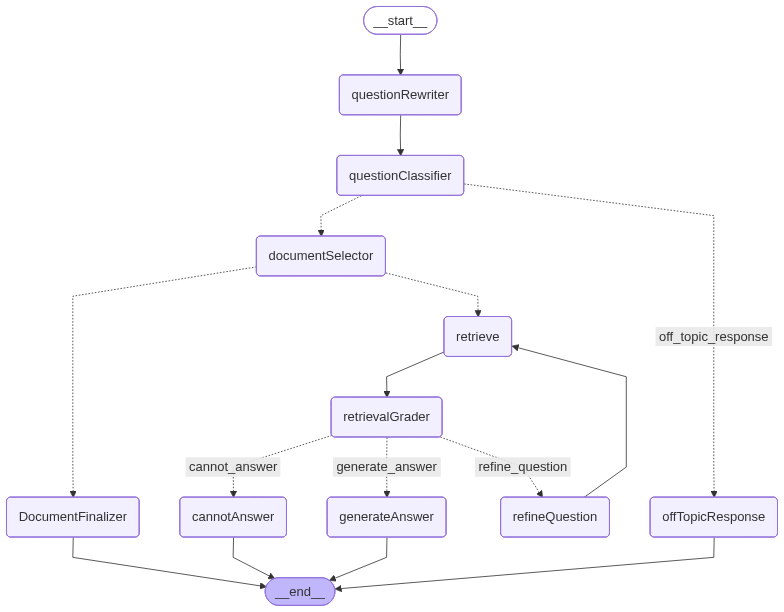

In [24]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [25]:
documents = [
    {
        "_id": "doc1",
        "type": "صحيفة دعوى",
        "metadata": {
            "court": "محكمة القاهرة الابتدائية",
            "case_number": "12345 لسنة 2025",
            "plaintiff": "أحمد محمد علي",
            "defendant": "شركة النور للتجارة",
            "date_filed": "2025-12-02"
        },
        "text": "محكمة القاهرة الابتدائية...\n\nمقدمة:\nبتاريخ 2 ديسمبر 2025، تقدم المدعي السيد أحمد محمد علي، بموجب هذه الصحيفة، بطلب دعوى قضائية ضد شركة النور للتجارة.\n\nالوقائع:\n1. بتاريخ 15 يناير 2025، وقع المدعي عقد بيع مع المدعى عليه...\n2. انتهكت الشركة شروط العقد بعدم تسليم البضاعة في الموعد المتفق عليه...\n\nالأسانيد القانونية:\nبموجب نصوص القانون المدني المصري، المادة 115، فإن عدم الوفاء بالتزامات العقد يُعد إخلالاً بالعقد...\n\nالطلبات:\n1. إلزام المدعى عليه بتسليم البضاعة المتفق عليها.\n2. تعويض المدعي عن الأضرار المادية والمعنوية الناتجة عن التأخير.\n3. إلزام المدعى عليه بالمصاريف القضائية.\n\nالمستندات المرفقة:\n- نسخة من العقد الأصلي.\n- إيصالات الدفع.\n- مراسلات بين الطرفين.\n\nالختام:\nوبناءً على ما سبق، يلتمس المدعي قبول الدعوى وإصدار حكم لصالحه وفقاً للقانون.\n\nتوقيع المدعي: أحمد محمد علي\nتاريخ: 2 ديسمبر 2025"
    },
    {
        "_id": "doc2",
        "type": "إعلان بصحيفة دعوى",
        "metadata": {
            "court": "محكمة القاهرة الابتدائية",
            "case_number": "12346 لسنة 2025",
            "plaintiff": "سعيد محمود حسن",
            "defendant": "شركة الأمل للاستيراد",
            "date_filed": "2025-12-03"
        },
        "text": "إعلان بصحيفة دعوى...\n\nمقدمة:\nبتاريخ 3 ديسمبر 2025، تقدم المدعي السيد سعيد محمود حسن، بإعلان رسمي بصحيفة دعوى ضد شركة الأمل للاستيراد.\n\nالوقائع:\n1. قام المدعي بتقديم طلب رسمي بتاريخ 10 فبراير 2025...\n2. لم يلتزم المدعى عليه بالشروط المحددة في العقد المبرم بين الطرفين...\n\nالأسانيد القانونية:\nوفقاً لنصوص القانون المدني المصري، المادة 110، فإن عدم الرد على الالتزامات العقدية يُعتبر إخلالاً بالعقد...\n\nالطلبات:\n1. إلزام المدعى عليه بالوفاء بالتزاماته العقدية.\n2. التعويض عن أي أضرار مباشرة أو غير مباشرة...\n\nالمستندات المرفقة:\n- نسخة من العقد.\n- إيصالات الدفع.\n- مراسلات رسمية.\n\nالختام:\nيطلب المدعي قبول هذا الإعلان وفقاً للقانون.\n\nتوقيع المدعي: سعيد محمود حسن\nتاريخ: 3 ديسمبر 2025"
    },
    {
        "_id": "doc3",
        "type": "مذكرة بدفاع",
        "metadata": {
            "court": "محكمة القاهرة الابتدائية",
            "case_number": "12347 لسنة 2025",
            "defendant": "شركة السلام للتجارة",
            "plaintiff": "محمود علي عبد الرحمن",
            "date_filed": "2025-12-04"
        },
        "text": "مذكرة بدفاع...\n\nمقدمة:\nبتاريخ 4 ديسمبر 2025، تقدم المدعى عليه مذكرة بدفاع ضد الدعوى المقامة من السيد محمود علي عبد الرحمن.\n\nالوقائع:\n1. أنكر المدعى عليه صحة المطالبات الواردة في صحيفة الدعوى.\n2. يثبت بالوثائق أن العقد تم تنفيذه وفق الشروط المتفق عليها...\n\nالأسانيد القانونية:\nالمادة 120 من القانون المدني المصري تنص على وجوب التثبت من صحة الالتزامات قبل المطالبة بالتعويض...\n\nالطلبات:\n1. رفض الدعوى المرفوعة من المدعي.\n2. تحميل المدعي كافة المصاريف القضائية.\n\nالمستندات المرفقة:\n- نسخة من العقد الأصلي.\n- إيصالات دفع.\n- مراسلات قانونية.\n\nالختام:\nوبناءً على ما سبق، نطلب رفض الدعوى.\n\nتوقيع المحامي: أحمد عبد الرحمن\nتاريخ: 4 ديسمبر 2025"
    },
    {
        "_id": "doc4",
        "type": "حافظة مستندات",
        "metadata": {
            "court": "محكمة القاهرة الابتدائية",
            "case_number": "12348 لسنة 2025",
            "owner": "هالة سمير علي",
            "date_created": "2025-12-05"
        },
        "text": "حافظة مستندات...\n\nمقدمة:\nتم إعداد هذه الحافظة لتجميع كافة المستندات المتعلقة بالقضية رقم 12348 لسنة 2025.\n\nالمستندات المرفقة:\n1. صحيفة الدعوى الأصلية.\n2. عقود الاتفاق بين الأطراف.\n3. إيصالات الدفع والمراسلات الرسمية.\n4. تقرير خبير محاسب حول الأضرار المالية.\n\nالوصف التفصيلي لكل مستند:\n- صحيفة الدعوى: تحتوي على جميع البيانات القانونية الخاصة بالقضية.\n- العقود: عقود البيع والشراء المبرمة بين الأطراف.\n- إيصالات الدفع: إثبات دفع المبالغ المالية.\n- تقرير الخبير: تحليل مفصل للخسائر.\n\nالختام:\nتم إعداد هذه الحافظة لضمان سهولة الوصول إلى جميع المستندات القانونية المطلوبة.\n\nتوقيع المسؤول عن الحافظة: هالة سمير علي\nتاريخ: 5 ديسمبر 2025"
    },
    {
        "_id": "doc5",
        "type": "محضر جلسة",
        "metadata": {
            "court": "محكمة القاهرة الابتدائية",
            "session_number": "5",
            "case_number": "12349 لسنة 2025",
            "judge": "القاضي سامي عبد الله",
            "date": "2025-12-06"
        },
        "text": "محضر جلسة...\n\nجلسة رقم: 5\nالقاضي: سامي عبد الله\nتاريخ الجلسة: 6 ديسمبر 2025\n\nالوقائع:\n1. استمع القاضي إلى أقوال المدعي والمدعى عليه.\n2. تم تقديم المستندات المرفقة.\n\nالمداولات:\n- ناقش القاضي صحة العقود المرفقة.\n- تم التأكد من حضور الأطراف والشهود.\n\nالقرارات:\n1. تأجيل الجلسة لتقديم مستندات إضافية.\n2. تحديد موعد الجلسة القادمة بتاريخ 20 ديسمبر 2025.\n\nالختام:\nتم تحرير المحضر وتوقيعه من قبل جميع الأطراف.\n\nتوقيع القاضي: سامي عبد الله\nتوقيع الأمين: محمد فتحي"
    },
    {
        "_id": "doc6",
        "type": "حكم ابتدائي",
        "metadata": {
            "court": "محكمة القاهرة الابتدائية",
            "case_number": "12350 لسنة 2025",
            "judge": "القاضي مصطفى عبد الرحيم",
            "date": "2025-12-07"
        },
        "text": "حكم ابتدائي...\n\nمقدمة:\nصدر الحكم الابتدائي في القضية رقم 12350 لسنة 2025 برئاسة القاضي مصطفى عبد الرحيم.\n\nالوقائع:\n1. تم النظر في الدعوى المقامة من السيد أحمد حسن ضد شركة الريان.\n2. تبين أن الشركة لم تلتزم ببنود العقد المتفق عليها.\n\nالأسانيد القانونية:\nبموجب القانون المدني المصري، المواد 115 و 117، فإن عدم الوفاء بالتزامات العقد يُعد إخلالاً بالعقد ويحق للمتضرر طلب التعويض.\n\nالحكم:\n1. إلزام المدعى عليه بتسليم البضاعة المتفق عليها.\n2. دفع تعويض للمدعي بمبلغ 50,000 جنيه.\n3. تحميل المدعى عليه كافة المصاريف القضائية.\n\nتوقيع القاضي: مصطفى عبد الرحيم\nتاريخ: 7 ديسمبر 2025"
    },
    {
        "_id": "doc7",
        "type": "حكم استئنافي",
        "metadata": {
            "court": "محكمة القاهرة الاستئنافية",
            "case_number": "12351 لسنة 2025",
            "judge": "القاضي أحمد عبد الغني",
            "date": "2025-12-08"
        },
        "text": "حكم استئنافي...\n\nمقدمة:\nتمت دراسة الاستئناف المقدم من السيد خالد محمد ضد الحكم الابتدائي الصادر في القضية رقم 12351 لسنة 2025.\n\nالوقائع:\n1. الحكم الابتدائي صدر ضد المدعي بمبلغ تعويض 30,000 جنيه.\n2. تم تقديم استئناف للطعن في مبلغ التعويض.\n\nالأسانيد القانونية:\nالمادة 156 من قانون الإجراءات المدنية والاستئناف تمنح الحق للطرفين في استئناف الحكم الابتدائي.\n\nالحكم:\n1. تعديل مبلغ التعويض ليصبح 40,000 جنيه.\n2. تأييد باقي الحكم.\n3. تحميل طرف الاستئناف المصاريف القضائية.\n\nتوقيع القاضي: أحمد عبد الغني\nتاريخ: 8 ديسمبر 2025"
    },
    {
        "_id": "doc8",
        "type": "صحيفة استئناف",
        "metadata": {
            "court": "محكمة القاهرة الاستئنافية",
            "case_number": "12352 لسنة 2025",
            "plaintiff": "سارة محمد علي",
            "defendant": "شركة النور للتجارة",
            "date_filed": "2025-12-09"
        },
        "text": "صحيفة استئناف...\n\nمقدمة:\nبتاريخ 9 ديسمبر 2025، قدمت المدعية سارة محمد علي صحيفة استئناف ضد الحكم الابتدائي الصادر في القضية رقم 12352 لسنة 2025.\n\nالوقائع:\n1. الحكم الابتدائي لم يلبي المطالب القانونية الكاملة للمدعية.\n2. المدعية تطعن في مبلغ التعويض المقرر.\n\nالأسانيد القانونية:\nالمادة 156 من قانون الإجراءات المدنية، تنص على حق الطرفين في الاستئناف خلال 30 يوم من صدور الحكم.\n\nالطلبات:\n1. زيادة مبلغ التعويض إلى 75,000 جنيه.\n2. إلزام المدعى عليه بالمصاريف القضائية.\n\nتوقيع المدعية: سارة محمد علي\nتاريخ: 9 ديسمبر 2025"
    },
    {
        "_id": "doc9",
        "type": "صحيفة إدخال/تصحيح",
        "metadata": {
            "court": "محكمة القاهرة الابتدائية",
            "case_number": "12353 لسنة 2025",
            "plaintiff": "محمد سامي عبد الله",
            "date_filed": "2025-12-10"
        },
        "text": "صحيفة إدخال/تصحيح...\n\nمقدمة:\nبتاريخ 10 ديسمبر 2025، تقدم المدعي محمد سامي عبد الله بطلب إدخال بيانات وتصحيح أخطاء في الدعوى رقم 12353 لسنة 2025.\n\nالوقائع:\n1. لاحظ المدعي وجود أخطاء في أسماء الأطراف.\n2. تصحيح بعض التفاصيل المتعلقة بالمستندات المرفقة.\n\nالأسانيد القانونية:\nوفقاً لقانون المرافعات المدنية، يحق للمدعي طلب تصحيح أي خطأ جوهري في البيانات المقدمة.\n\nالطلبات:\n1. إدخال البيانات الصحيحة.\n2. تعديل المستندات المرفقة بما يتوافق مع الحقيقة.\n\nتوقيع المدعي: محمد سامي عبد الله\nتاريخ: 10 ديسمبر 2025"
    },
    {
        "_id": "doc10",
        "type": "أمر على عريضة",
        "metadata": {
            "court": "محكمة القاهرة الابتدائية",
            "case_number": "12354 لسنة 2025",
            "judge": "القاضي محمود فؤاد",
            "date": "2025-12-11"
        },
        "text": "أمر على عريضة...\n\nمقدمة:\nبتاريخ 11 ديسمبر 2025، أصدر القاضي محمود فؤاد أمر على عريضة مقدمة من السيد علي حسني.\n\nالوقائع:\n1. تقدم المدعي بعريضة للمطالبة بحقوقه المالية.\n2. تم التأكد من صحة البيانات والمستندات المرفقة.\n\nالأسانيد القانونية:\nالمادة 60 من قانون المرافعات المدنية تنص على أن القاضي له الحق في إصدار أمر على العريضة بعد التأكد من صحتها.\n\nالأمر:\nإلزام المدعى عليه بدفع مبلغ 25,000 جنيه للمدعي خلال 30 يوم.\n\nتوقيع القاضي: محمود فؤاد\nتاريخ: 11 ديسمبر 2025"
    },
    # Continue with doc11 ("أمر وقتي") to doc18 ("محضر صلح") in the same detailed style
]


In [26]:
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter # <-- CORRECT

# 1. Initialize the Text Splitter
# Define chunk size and overlap. Adjust these based on your model's context window.
chunk_size = 500  # Characters per chunk
chunk_overlap = 50 # Overlap between chunks for context continuity

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    length_function=len,
    separators=["\n\n", "\n", " ", ""] # Legal docs often use double newlines for sections
)

source_documents = []

for doc in documents:
    # Prepare metadata: Flattening and including top-level fields
    doc_metadata = doc["metadata"].copy()
    doc_metadata["type"] = doc["type"]
    doc_metadata["mongo_id"] = doc["_id"]
    
    source_documents.append(
        Document(page_content=doc["text"], metadata=doc_metadata)
    )


chunked_documents = text_splitter.split_documents(source_documents)

print(f"Original documents: {len(source_documents)}")
print(f"Chunked documents: {len(chunked_documents)}")

db.add_documents(chunked_documents)

print("Chunked documents successfully added to ChromaDB.")

Original documents: 10
Chunked documents: 17
Chunked documents successfully added to ChromaDB.


In [28]:
test_prompts = [
    "ما هي أفضل المطاعم في القاهرة؟",
    "اعرض لي النص الكامل لمستند صحيفة الدعوى.",
    "من هو القاضي المذكور في الحكم الاستئنافي؟",
    "ما هي طلبات المدعي أحمد محمد علي في هذه القضية؟",
    "ما هو رقم البطاقة الشخصية (الرقم القومي) للمدعي؟"
]

for q in test_prompts:
    print(f"\n--- Testing Query: {q} ---")
    inputs = {"query": HumanMessage(content=q)}
    try:
        # Run the graph
        result = app.invoke(inputs)
        
        # Print the final response
        if result.get("messages"):
            print(f"Response: {result['messages'][-1].content}")
        elif result.get("retrieved_docs") and result.get("doc_selection_mode") == "retrieve_specific_doc":
             print(f"Document Fetched: {result['retrieved_docs'].get('_id')}")
    except Exception as e:
        print(f"Error: {e}")


--- Testing Query: ما هي أفضل المطاعم في القاهرة؟ ---
Entering question_rewriter with following state: {'query': HumanMessage(content='ما هي أفضل المطاعم في القاهرة؟', additional_kwargs={}, response_metadata={})}
question_rewriter: No rephrasing needed for question: ما هي أفضل المطاعم في القاهرة؟
Entering question_classifier
question_classifier: on_topic = No
Entering on_topic_router
Routing to off_topic_response
Entering offTopicResponse
Response: عذراً، لا يمكنني الإجابة على هذا السؤال لأنه خارج نطاق المستندات أو غير متعلق بالمسائل القانونية المرتبطة بالدعوى المدنية محل البحث.

--- Testing Query: اعرض لي النص الكامل لمستند صحيفة الدعوى. ---
Entering question_rewriter with following state: {'query': HumanMessage(content='اعرض لي النص الكامل لمستند صحيفة الدعوى.', additional_kwargs={}, response_metadata={})}
question_rewriter: No rephrasing needed for question: اعرض لي النص الكامل لمستند صحيفة الدعوى.
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_r